# Exercise 6: Position of a quasar
You measure the position of a quasar $N$ times with the *same* telescope i.e. errors are homoscedastic. Let's say the true position is $\mu = 1$ (in suitable units) and the erorrs are $\sigma=0.2$

### Part 1

- Generate fake measurements. Treat each of these observations as an estimate of the true distribution. So we'll center a Gaussian (with the known $\sigma$) at each point. This is the probability of each data point, $p(x_i|\mu,\sigma)$.
- Plot each of the individual likelihoods separately.  Also plot their product (i.e. the likelihood of the dataset $\{x_i\}$). Make sure the x grid has enough points.
- Just read off the maximum likelihood solution (e.g. using `np.argsort`) 
- Compare it with the MLE estimator derived above

### Part 2

Check the Fisher matrix error estimate makes sense
- do a rough $2^\mathrm{nd}$ order differentation of our log-likelihood function with `np.diff`, 
- divide through by our $\Delta \theta^2$ to get the correct normalization, 
- multiply by $-1$, 
- then take the square root.
- Compare with the Fisher matrix error derived above
- Plot a Gaussian at the measured $\mu$ with this error as the scale to see if it matches the numerical likelihood distribution. (The normalization won't be captured, you can rescale it as you like to check it agrees) 

### Part 3

Let's make our model more realistic. Our $N$ measurements were taken in different nights, where the sky behaved differently (i.e. errors are heteoscedastic). Let's assume that each measurment has a $\sigma_i$ that is normally distribured with mean $0.2$ and standard deviation $0.05$

- Generalize your code from above to this case

In [140]:
import numpy as np
from scipy import stats

rng = np.random.default_rng(404)

N = 100 # number of measurements
mu = 1.
sigma = 0.2
# sig = np.full(N,sigma)
sig = rng.normal(loc=sigma, scale=0.05, size=N)

x_sample = np.array([rng.normal(loc=mu, scale=q) for q in sig ])

sample = np.vstack((x_sample,sig)).T
sample = sample[sample[:,0].argsort(), :]

dist_list=[]
for i, (x,s) in enumerate(sample):
    dist = stats.norm(loc=x, scale=s)
    dist_list.append(dist)

def L(x):
    prod = 1
    for dist in dist_list:
        prod *= dist.pdf(x)
    return prod

w_mean = np.sum(sample[:,0]/sample[:,1]**2)/np.sum(1/sample[:,1]**2)
sigma_est = np.sum(1/sig**2)**(-1/2)
sigma_homo = sigma / np.sqrt(N)



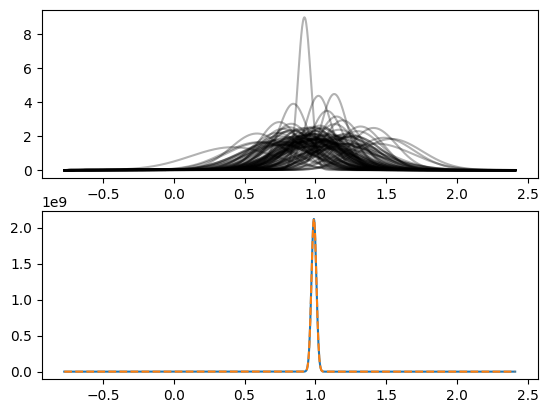

In [146]:
import pylab as plt
from scipy import optimize as opt

def gauss(x,mu,sigma,a):
    return stats.norm(loc=mu, scale=sigma).pdf(x)*a

n_points = 1000
x_grid = np.linspace(sample[0,0]-4*sample[0,1], sample[-1,0]+4*sample[-1,1], n_points )

fig,ax = plt.subplots(2,1)

for e in dist_list:
    ax[0].plot(x_grid, e.pdf(x_grid), alpha=0.3, c='k')

ax[1].plot(x_grid, L(x_grid))

popt, pcov = opt.curve_fit(gauss, x_grid, L(x_grid), (mu,sigma,30))

ax[1].plot(x_grid, gauss(x_grid, *popt), ls='--' )



In [143]:
max_L = L(x_grid)[np.argmax(L(x_grid))]
max_L_loc = x_grid[np.argmax(L(x_grid))]
print(f'Maximum Likelihood at x = {max_L_loc:.5} +- {popt[1]:.5} with L = {max_L:.2}')
print(f'ML theoretical estimator = {w_mean:.5} +- {sigma_est:.5}')
print(f'Computed result differs from analytic estimator by {np.abs(max_L_loc-w_mean)/w_mean:.2}%')

Maximum Likelihood at x = 0.98919 +- 0.017291 with L = 2.1e+09
ML theoretical estimator = 0.98957 +- 0.017291
Computed result differs from analytic estimator by 0.00039%


Uncertainty calculated from Fisher matrix = 0.017291


/tmp/ipykernel_690/3754176327.py:11: RuntimeWarning: divide by zero encountered in log
  logL = np.log(L(grid2))
/home/fra/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:1423: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


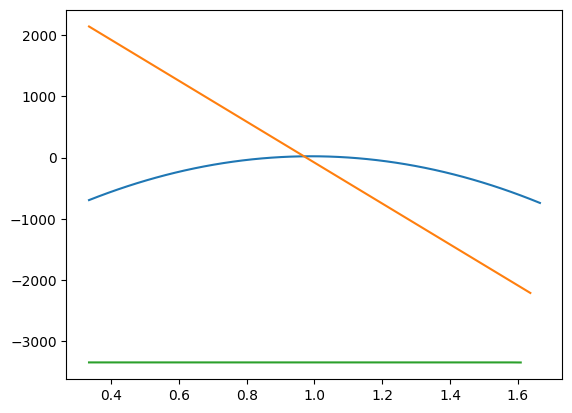

In [144]:
n_grid2 = 100
grid2 = np.linspace(mu-7*sigma,mu+7*sigma,n_grid2)

max_L = L(grid2)[np.argmax(L(grid2))]
max_L_loc = grid2[np.argmax(L(grid2))]

def deriv (func_arr,grid):
    delta = grid[1]-grid[0]
    return np.diff(func_arr)/delta

logL = np.log(L(grid2))
der = deriv(logL,grid2)
sec_der = deriv(der,grid2)

p = sec_der[np.argmax(L(grid2))]
sigma_fish = np.sqrt(1/(-p))

print(f'Uncertainty calculated from Fisher matrix = {sigma_fish:.5}')

plt.plot(grid2, logL)
plt.plot(grid2[:-1], der)
plt.plot(grid2[:-2], sec_der)
